In [1]:
%%capture
!rm -rf data/
!mkdir data
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/lndst/v0.1/test_images.zip
!unzip test_images -d data/

In [2]:
import warnings
import torch
import time
import re 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla P100-PCIE-16GB


In [4]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [6]:
ROOT = Path("/content/data/")
MODELROOT = Path("/content/drive/My Drive/Competition/LNDST/")

!ls "/content/data"

test_images


## **DataLoading**

In [7]:
files = []
for file in get_image_files(ROOT/'test_images'):
    files.append(file.name)

pattern = re.compile('\d+')
def f(filename):
    num = re.search(pattern, filename).group(0)
    return int(num)
files.sort(key=lambda x: f(x))

In [8]:
test_df = pd.DataFrame({'filename':files})
test_df.head()

,filename
0,image_0.jpg
1,image_1.jpg
2,image_2.jpg
3,image_3.jpg
4,image_4.jpg


In [9]:
get_y_fn = lambda x: x
data_list = SegmentationItemList.from_folder(path=ROOT/'test_images').split_by_rand_pct(0.2).label_from_func(get_y_fn, classes=['land','water'])
test_list = SegmentationItemList.from_df(path=ROOT, df=test_df, cols=['filename'], folder='test_images')
data_list.add_test(test_list)

def get_data(image_size, batch_size):
    # tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
    data = (data_list.transform(
            tfms=None,
            tfm_y=False,
            size=image_size,
            resize_method=ResizeMethod.SQUISH)
                .databunch(bs=batch_size)
                .normalize(imagenet_stats))
    data.num_workers = 4
    return data

## **Test**

In [10]:
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

binarize_func = np.vectorize(lambda x: 0 if x>0.7 else 1)

In [11]:
%%capture
learn = unet_learner(get_data(400, 1), models.resnet50, metrics=acc, pretrained=True, wd=1e-2)
learn.model_dir = MODELROOT/'checkpoints'
learn.load('resnet_400')

In [12]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [15]:
temp_preds = preds[0][:,0,:,:].cpu().detach().numpy()

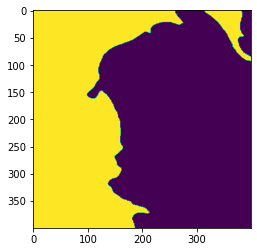

In [28]:
tester = temp_preds[0]
plt.imshow(binarize_func(tester))

In [29]:
temp_preds = temp_preds.reshape(-1)
final_preds = binarize_func(temp_preds)

In [30]:
final_preds = np.array(final_preds, dtype=np.int8)
final_preds.shape

(74720000,)

In [33]:
np.save('submission1.npy', final_preds)

## Analyze

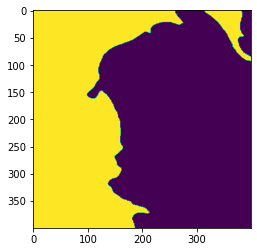

In [32]:
plt.imshow(final_preds[:160000].reshape(400,400))

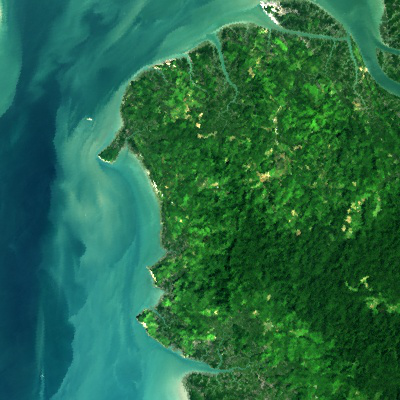

In [ ]:
open_image(ROOT/'test_images/image_0.jpg')

In [ ]:
final_preds[:160000].reshape(400,400)[0]

array([0, 0, 0, 0, ..., 1, 1, 1, 1], dtype=int8)